In [1]:
import numpy as np
import cirq
from scipy.linalg import expm
from scipy.sparse import diags, identity
from scipy.special import genlaguerre
import math


Reactant center ~ 1.55 1.4
Product  center ~ 1.4 1.55


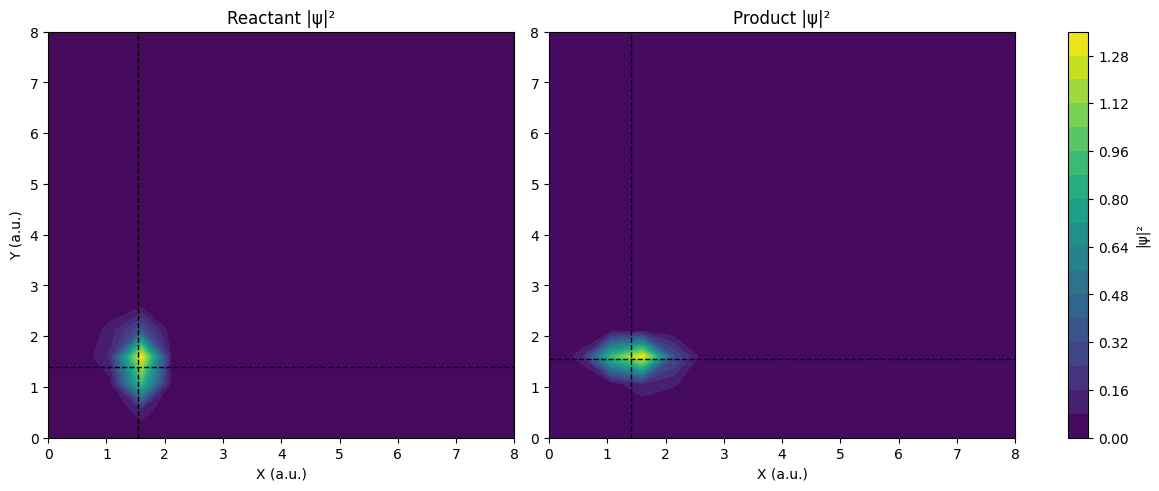

In [2]:
# === Kale–Kais Fig. 2(a) setup: reactant packet in bond coords (X,Y) ===
import numpy as np, math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre   # L_n^{(α)}(z)

# --- Morse vibrational eigenfunction ψ_vib(r) (n = 0 by default) ---
def morse_vibrational_wavefunction(r, D_e=0.1745, a=1.02, r_e=1.4, n=0,
                                   mu=918.076, hbar=1.0):
    """
    All quantities in atomic units.
    mu = reduced mass for H–H (m_H/2) ≈ 1836.15 m_e.
    """
    r = np.asarray(r, dtype=float)
    lam = math.sqrt(2.0 * mu * D_e) / (a * hbar)         # λ
    alpha = 2.0*lam - 2.0*n - 1.0                        # Laguerre parameter
    z = 2.0*lam * np.exp(-a*(r - r_e))
    L_n = genlaguerre(n, alpha)                          # L_n^{(α)}(·)
    # N_n from orthonormality of Morse eigenstates
    N_n = math.sqrt(math.factorial(n) * (2.0*lam - 2.0*n - 1.0) * a
                    / math.gamma(2.0*lam - n))
    return N_n * (z**(lam - n - 0.5)) * np.exp(-0.5*z) * L_n(z)

# --- Channel packet ψ_in(R, r) = ψ_vib(r) × Gaussian(R) × plane-wave(R) ---
def psi_wavepacket(R, r, Delta_k, k0, R0, r_params=None):
    if r_params is None: r_params = {}
    psi_vib_r  = morse_vibrational_wavefunction(r, **r_params).astype(np.complex128)
    gaussian_R = np.exp(- (Delta_k**2) * (R - R0)**2).astype(np.complex128)
    carrier_R  = np.exp(1j * k0 * (R - R0))
    prefactor  = ((2.0 * (Delta_k**2)) / np.pi) ** 0.25
    return prefactor * psi_vib_r * gaussian_R * carrier_R

# --- Grid in bond coordinates (X,Y) ---


NX = NY = 16
Xmax = Ymax = 8
X = np.linspace(0.0, Xmax, NX)
Y = np.linspace(0.0, Ymax, NY)   # bohr
Xg, Yg = np.meshgrid(X, Y, indexing="ij")


# --- Eq. (3): bond <-> Jacobi transforms (collinear H + H2) ---
# Reactant channel: (X, Y) = (R1 - 0.5 r1, r1)  ⇒  r1 = Y,  R1 = X + 0.5Y
r1 = Yg
R1 = Xg + 0.5*Yg
# (Product channel if/when needed:)
r2 = Xg
R2 = Yg + 0.5*Xg

# --- Paper parameters (SI): Δk, k0, R0 for reactant packet ---
Delta_k = 1.25
k0_re   = -8.2
R0      = 2.25
k0_pr   = +8.2


# --- Build and normalize ψ_in on (X,Y) ---
psi_react_XY = psi_wavepacket(R1, r1, Delta_k=Delta_k, k0=k0_re, R0=R0,
                              r_params=dict(D_e=0.1745, a=1.02, r_e=1.4,
                                            n=0, mu=986.15, hbar=1.0))

dx, dy = X[1]-X[0], Y[1]-Y[0]
norm = np.sqrt((np.abs(psi_react_XY)**2).sum() * dx * dy)
psi_react_XY /= norm


# If you want v'=0 in product, keep n=0; change n to 1 or 2 for v'=1,2
r_params_prod = dict(D_e=0.1745, a=1.02, r_e=1.4, n=0, mu=986.15, hbar=1.0)

psi_prod_XY = psi_wavepacket(R2, r2, Delta_k=Delta_k, k0=k0_pr, R0=R0,
                             r_params=r_params_prod)



# Expected centers using r_e for the chosen vibrational state(s)
r_e = r_params_prod["r_e"]
Xctr_react, Yctr_react = (R0 - 0.5*r_e), r_e          # (R1-0.5 r1 , r1)
Xctr_prod , Yctr_prod  = r_e, (R0 - 0.5*r_e)          # (r2 , R2-0.5 r2)
print("Reactant center ~", Xctr_react, Yctr_react)
print("Product  center ~", Xctr_prod , Yctr_prod )

# --- Plot side-by-side ---
fig, axs = plt.subplots(1,2, figsize=(11.5,4.8), constrained_layout=True)
# Reactant (like Fig. 2a)
cf0 = axs[0].contourf(X, Y, np.abs(psi_react_XY)**2, levels=20)
axs[0].plot([Xctr_react,Xctr_react],[0,Ymax],'k--',lw=1)
axs[0].plot([0,Xmax],[Yctr_react,Yctr_react],'k--',lw=1)
axs[0].set(xlim=(0,Xmax), ylim=(0,Ymax), xlabel='X (a.u.)', ylabel='Y (a.u.)',
           title='Reactant |ψ|²')

# Product (like Fig. 2b)
cf1 = axs[1].contourf(X, Y, np.abs(psi_prod_XY)**2, levels=20)
axs[1].plot([Xctr_prod,Xctr_prod],[0,Ymax],'k--',lw=1)
axs[1].plot([0,Xmax],[Yctr_prod,Yctr_prod],'k--',lw=1)
axs[1].set(xlim=(0,Xmax), ylim=(0,Ymax), xlabel='X (a.u.)', title='Product |ψ|²')

# One shared colorbar
cbar = fig.colorbar(cf1, ax=axs.ravel().tolist())
cbar.set_label('|ψ|²')
plt.show()


/tmp/ipykernel_2824118/4033716534.py:47: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.88)


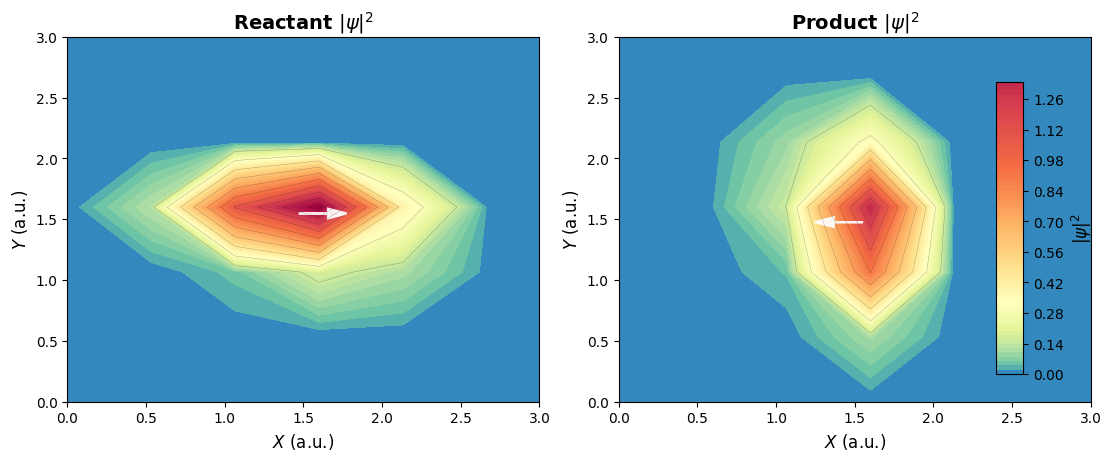

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- compute magnitudes ---
mag_react = np.abs(psi_react_XY)**2
mag_prod  = np.abs(psi_prod_XY)**2

# --- shared normalization ---
vmin, vmax = 0.0, max(np.max(mag_react), np.max(mag_prod))

# --- setup figure ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)

# improved colormap: smooth and vivid, good perceptual contrast
cmap = 'Spectral_r'
      # alternatives: 'Spectral_r', 'viridis', 'magma'
titles = [r'Reactant $|\psi|^2$', r'Product $|\psi|^2$']
mags   = [mag_react, mag_prod]

for ax, mag, title in zip(axes, mags, titles):
    cf = ax.contourf(
        Xg, Yg, mag, levels=80, cmap=cmap,
        norm=colors.PowerNorm(0.45), vmin=vmin, vmax=vmax
    )
    # soft contour outlines
    ax.contour(Xg, Yg, mag, levels=10, colors='k', linewidths=0.25, alpha=0.4)
    
    # labels and limits
    ax.set_xlabel(r'$X$ (a.u.)', fontsize=12)
    ax.set_ylabel(r'$Y$ (a.u.)', fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlim(0, 3.0)
    ax.set_ylim(0, 3.0)
    
    # compute centroid and add propagation arrow
    x_mean = np.sum(Xg * mag) / np.sum(mag)
    y_mean = np.sum(Yg * mag) / np.sum(mag)
    arrow_dx = 0.3 if 'Reactant' in title else -0.3
    ax.arrow(x_mean, y_mean, arrow_dx, 0, color='white',
             head_width=0.08, lw=1.6, length_includes_head=True, alpha=0.9)
    
    # subtle dark background frame
    ax.set_facecolor('#0E1117')

# --- shared colorbar ---
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.18, 0.025, 0.65])
cb = fig.colorbar(cf, cax=cax)
cb.set_label(r'$|\psi|^2$', fontsize=12)
cb.ax.tick_params(labelsize=10)

plt.show()


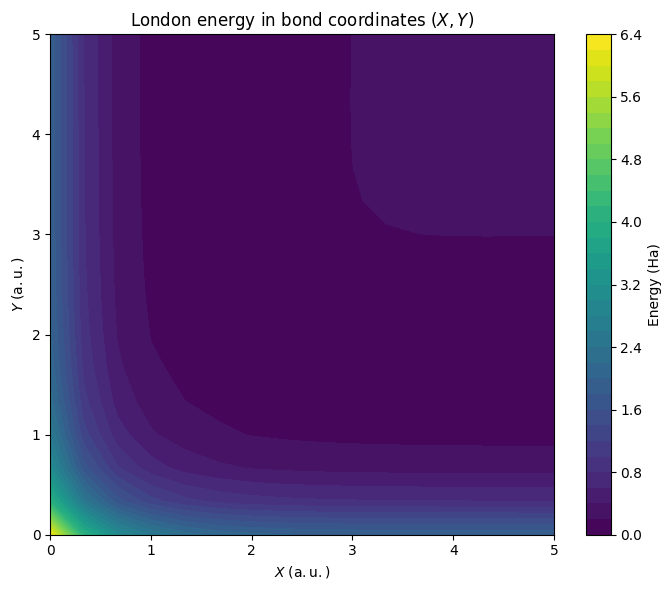

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- your primitives, unchanged ---
def morse_function(r, De, beta, re):
    return De * (1 - np.exp(-beta * (r - re)))**2

def anti_morse_function(r, De, beta, re):
    return 0.5 * De * (np.exp(-2*beta*(r-re)) + 2*np.exp(-beta*(r-re)))

def coulomb_and_exchange_integrals(De, beta, re, r):
    sigma_1 = morse_function(r, De, beta, re)
    sigma_3 = anti_morse_function(r, De, beta, re)
    Q = 0.5 * (sigma_1 + sigma_3)
    alpha = 0.5 * (sigma_1 - sigma_3)
    return Q, alpha

def london_energy(Qa, Qb, Qc, aa, ab, ac, sign=-1):
    t1 = (aa - ab)**2
    t2 = (aa - ac)**2
    t3 = (ac - ab)**2
    return Qa + Qb + Qc + sign*(2**-0.5)*np.sqrt(t1 + t2 + t3)

# --- wrapper in (X,Y) bond coordinates ---
def london_energy_XY(X, Y, De, beta, re, use_abs=True):
    """
    London energy on the bond-length grid (X,Y).
    X, Y in a.u. For collinear geometries take r13 = r12 + r23.
    If use_abs=True, reflect to positive bond lengths via |X|, |Y|.
    """
    r12 = np.abs(X) if use_abs else X
    r23 = np.abs(Y) if use_abs else Y
    r13 = r12 + r23

    Qa, aa = coulomb_and_exchange_integrals(De, beta, re, r12)
    Qb, ab = coulomb_and_exchange_integrals(De, beta, re, r23)
    Qc, ac = coulomb_and_exchange_integrals(De, beta, re, r13)

    return london_energy(Qa, Qb, Qc, aa, ab, ac, sign=-1)

# ---- build an (X,Y) grid and plot ----
De, re, beta =0.174, 1.41, 1.028     # 
X = np.linspace(0.0, 5.0, 16)         # 
Y = np.linspace(0.0, 5.0, 16)         # 
Xg, Yg = np.meshgrid(X, Y, indexing="ij")

V_XY = london_energy_XY(Xg, Yg, De, beta, re)  

plt.figure(figsize=(7,6))
cs = plt.contourf(Xg, Yg, V_XY, levels=30)
plt.colorbar(cs, label='Energy (Ha)')
plt.xlabel(r'$X \;(\mathrm{a.u.})$'); plt.ylabel(r'$Y \;(\mathrm{a.u.})$')
plt.title('London energy in bond coordinates $(X,Y)$')
plt.tight_layout(); plt.show()


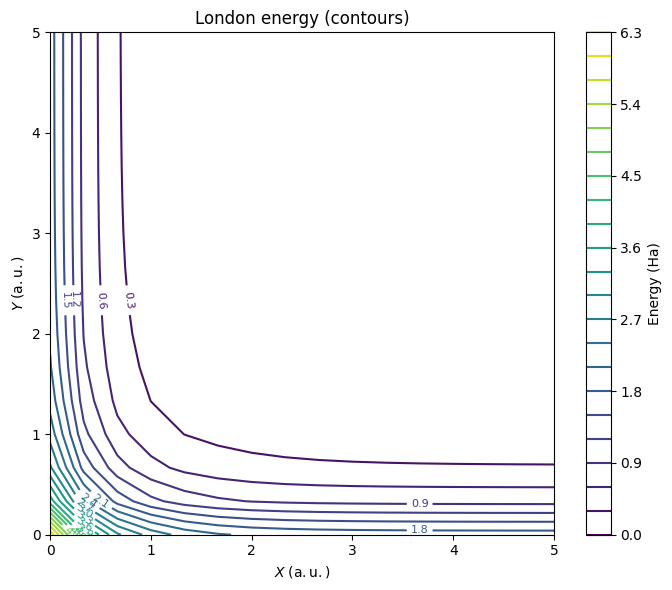

In [5]:
plt.figure(figsize=(7,6))
c = plt.contour(Xg, Yg, V_XY, levels=20)
plt.clabel(c, inline=True, fontsize=8)
plt.colorbar(c, label='Energy (Ha)')
plt.xlabel(r'$X\;(\mathrm{a.u.})$'); plt.ylabel(r'$Y\;(\mathrm{a.u.})$')
plt.title('London energy (contours)')
plt.tight_layout(); plt.show()


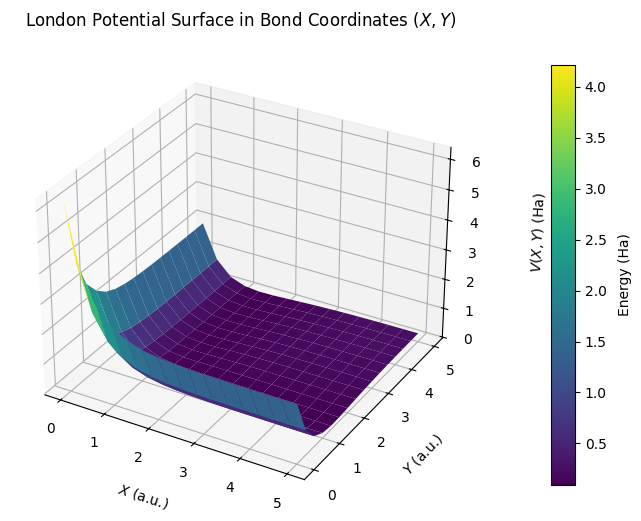

In [6]:
fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Xg, Yg, V_XY, cmap='viridis', edgecolor='none')

ax.set_xlabel(r'$X$ (a.u.)', labelpad=10)
ax.set_ylabel(r'$Y$ (a.u.)', labelpad=10)
ax.set_zlabel(r'$V(X,Y)$ (Ha)', labelpad=20)   # <-- more space from cbar
ax.set_title('London Potential Surface in Bond Coordinates $(X,Y)$', pad=15)

# leave room on the right for the colorbar
fig.subplots_adjust(right=0.86)

# dedicate a separate axes for the colorbar (x0, y0, width, height in figure coords)
cax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cb  = fig.colorbar(surf, cax=cax)
cb.set_label('Energy (Ha)', labelpad=8)

plt.show()


In [7]:
import numpy as np

from scipy.sparse import diags, kron, identity, csr_matrix

def build_XY_kinetic_periodic(X: np.ndarray, Y: np.ndarray,
                              mH: float = 1836.15267389) -> csr_matrix:
    """T = (-∂XX + ∂X∂Y - ∂YY)/mH on a uniform grid, periodic BCs.
       Flattening: idx = i*NY + j  (meshgrid(..., indexing='ij'); reshape(..., order='C'))."""
    NX, NY = len(X), len(Y)
    dX, dY = X[1]-X[0], Y[1]-Y[0]
    assert np.allclose(np.diff(X), dX) and np.allclose(np.diff(Y), dY)

    Dx  = diags([-0.5/dX, 0.0, +0.5/dX], [-1,0,+1], shape=(NX,NX)).tolil()
    Dy  = diags([-0.5/dY, 0.0, +0.5/dY], [-1,0,+1], shape=(NY,NY)).tolil()
    Dxx = diags([1/dX**2,-2/dX**2,1/dX**2], [-1,0,+1], shape=(NX,NX)).tolil()
    Dyy = diags([1/dY**2,-2/dY**2,1/dY**2], [-1,0,+1], shape=(NY,NY)).tolil()

#     # periodic wrap
#     Dx[0,-1] = -0.5/dX;  Dx[-1,0] = +0.5/dX
#     Dy[0,-1] = -0.5/dY;  Dy[-1,0] = +0.5/dY
#     Dxx[0,-1] = Dxx[-1,0] = 1/dX**2
#     Dyy[0,-1] = Dyy[-1,0] = 1/dY**2

    Dx, Dy, Dxx, Dyy = (A.tocsr() for A in (Dx,Dy,Dxx,Dyy))
    Ix, Iy = identity(NX, format="csr"), identity(NY, format="csr")

    T = (-kron(Dxx, Iy) + kron(Dx, Dy) - kron(Ix, Dyy)) * (1.0/mH)
#     T = (-kron(Dxx, Iy)  - kron(Ix, Dyy)) * (1.0/mH)
    return T

mH = 1836.15  # proton mass in a.u. (use this everywhere)

H0 = build_XY_kinetic_periodic(X, Y)       # sparse (NX*NY) x (NX*NY)




In [8]:
def num_qubits_from_unitary(U):
    d0, d1 = U.shape
    if d0 != d1:
        raise ValueError("Unitary must be square.")
    k = int(np.round(np.log2(d0)))
    if 2**k != d0:
        raise ValueError(f"Unitary dimension {d0} is not a power of two.")
    return k


In [9]:
V_op = diags(V_XY.reshape(-1), 0, format="csr")  # (NX*NY, NX*NY)


import cirq
import numpy as np

In [10]:
import numpy as np, cirq

# --- Numerically stable Householder: U|0...0> = |psi> ---
def unitary_preparing_state(psi, eps=1e-12):
    """
    Returns unitary U (complex128) such that U|0...0> = |psi>.
    psi: 1D array-like (length D=2**k), not necessarily normalized.
    Uses a stable Householder that avoids cancellation when psi[0] ~ 1.
    """
    psi = np.asarray(psi, dtype=np.complex128).ravel()
    D = psi.size
    if D & (D - 1):
        raise ValueError(f"psi length {D} is not 2**k")

    nrm = np.linalg.norm(psi)
    if not np.isfinite(nrm) or nrm < eps:
        raise ValueError("psi must be nonzero and finite")
    psi /= nrm

    e0 = np.zeros(D, dtype=np.complex128); e0[0] = 1.0

    # Trivial collinearity cases
    if np.allclose(psi,  e0, atol=eps):  # already |0...0>
        return np.eye(D, dtype=np.complex128)
    if np.allclose(psi, -e0, atol=eps):  # global -1 on |0>
        U = np.eye(D, dtype=np.complex128); U[0,0] = -1.0; return U

    # Stable Householder: v = psi + alpha*e0, alpha = e^{i arg(psi[0])}
    alpha = np.exp(1j * np.angle(psi[0])) if abs(psi[0]) > eps else 1.0 + 0.0j
    v = psi.copy()
    v[0] += alpha
    v_norm = np.linalg.norm(v)
    if v_norm < eps:
        # Fallback to standard reflector if something degenerate happens
        w = e0 - psi
        v = w / np.linalg.norm(w)
    else:
        v /= v_norm

    U = np.eye(D, dtype=np.complex128) - 2.0 * np.outer(v, v.conj())

    # Sanity check (tight tolerance in 128-bit)
    I = np.eye(D, dtype=np.complex128)
    if not np.allclose(U.conj().T @ U, I, atol=1e-12, rtol=1e-12):
        raise RuntimeError("Constructed matrix is not unitary to 1e-12.")
    return U

# --- Build |psi_r> and |psi_p> unitaries in complex128 ---
# --- your ψ_in builders (as you already have) produce psi_react_XY, psi_prod_XY on the grid ---

psi_r = np.asarray(psi_react_XY, np.complex128).reshape(NX*NY, order="C")
psi_p = np.asarray(psi_prod_XY , np.complex128).reshape(NX*NY, order="C")
psi_r /= np.linalg.norm(psi_r);  psi_p /= np.linalg.norm(psi_p)

U_r = unitary_preparing_state(psi_r)   # your Householder function (already correct)
U_p = unitary_preparing_state(psi_p)





In [11]:
H_sparse= H0+V_op

In [12]:
ancilla = cirq.LineQubit(0)
n_sys  = int(np.log2(NX*NY))
system_qubits = [cirq.LineQubit(i+1) for i in range(n_sys)]

def corr_at_time(H_sparse, t):
    # build U(t) = e^{-i H t} as a dense gate for this small test (4096 dim)
    from scipy.linalg import expm
    Uprop = expm((-1j * H_sparse).toarray() * t)
    Uprop0 = expm((-1j * H0).toarray() * t)
    Uprop0pos = expm((1j * H0).toarray() * t)
    Uproppos = expm((1j * H_sparse).toarray() * t)

    # gates
    G_Ur   = cirq.MatrixGate(U_r, name="U_r")
    G_Up   = cirq.MatrixGate(U_p, name="U_p")
    G_Ut   = cirq.MatrixGate(Uprop, name="U_t")
    G_Ut0   = cirq.MatrixGate(Uprop0, name="U_t0")
    G_Ut0p   = cirq.MatrixGate(Uprop0pos, name="U_t0p")
    G_Utp   = cirq.MatrixGate(Uproppos, name="U_tp")

    # Re C(t)
    c_re = cirq.Circuit(
        cirq.H(ancilla),
        G_Ur.on(*system_qubits).controlled_by(ancilla),                       # anc=1 → |ψ_r⟩
        G_Ut0p.on(*system_qubits).controlled_by(ancilla),
        G_Ut.on(*system_qubits).controlled_by(ancilla),
        G_Ut.on(*system_qubits).controlled_by(ancilla),
        G_Up.on(*system_qubits).controlled_by(ancilla, control_values=[0]),   # anc=0 → |ψ_p⟩
        G_Ut0.on(*system_qubits).controlled_by(ancilla, control_values=[0]),                       # propagate anc=1 branch
        G_Utp.on(*system_qubits).controlled_by(ancilla, control_values=[0]),
        cirq.H(ancilla),
    )
    sim = cirq.Simulator(dtype=np.complex128)
    sv  = sim.simulate(c_re, qubit_order=[ancilla, *system_qubits]).final_state_vector

    # ⟨Z⟩ on ancilla
    dim_sys = 2**n_sys
    ReC = 0.0
    for idx, amp in enumerate(sv):
        anc_bit = (idx // dim_sys) & 1
        ReC += (+1 if anc_bit==0 else -1) * (amp.conjugate()*amp).real

    # Im C(t) (add S† before final H)
    c_im = cirq.Circuit(
        cirq.H(ancilla), cirq.S(ancilla)**-1,
        G_Ur.on(*system_qubits).controlled_by(ancilla),
        G_Ut0p.on(*system_qubits).controlled_by(ancilla),
        G_Ut.on(*system_qubits).controlled_by(ancilla),
        G_Ut.on(*system_qubits).controlled_by(ancilla),
        G_Up.on(*system_qubits).controlled_by(ancilla, control_values=[0]),
        G_Ut0.on(*system_qubits).controlled_by(ancilla, control_values=[0]),                       # propagate anc=1 branch
        G_Utp.on(*system_qubits).controlled_by(ancilla, control_values=[0]),
        cirq.H(ancilla),
    )
    sv2 = sim.simulate(c_im, qubit_order=[ancilla, *system_qubits]).final_state_vector
    ImC = 0.0
    for idx, amp in enumerate(sv2):
        anc_bit = (idx // dim_sys) & 1
        ImC += (+1 if anc_bit==0 else -1) * (amp.conjugate()*amp).real
    return ReC, ImC


In [13]:
C0_direct = np.vdot(psi_p, psi_r)
Re0, Im0  = corr_at_time(H0, 0.0)
print("direct:", np.real(C0_direct), np.imag(C0_direct))
print("circuit:", Re0, Im0)   # should match to ~1e-12


direct: -0.5104367836802537 -0.506824620693793
circuit: -0.5104367836802538 -0.5068246206937929


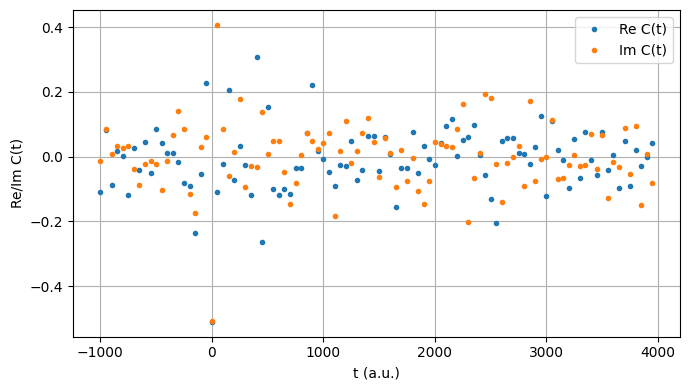

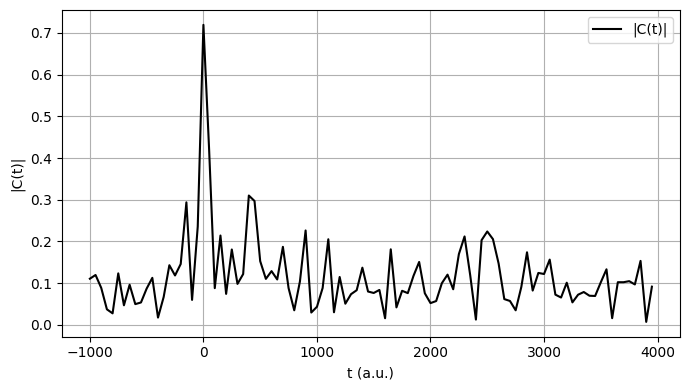

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- time grid ---
ts = np.arange(-1000.0, 4000.0, 50)

# --- collect values (only one call per t) ---
Re_vals, Im_vals, Abs_vals = [], [], []
for t in ts:
    ReC, ImC = corr_at_time(H_sparse, t)   # one call
    Re_vals.append(ReC)
    Im_vals.append(ImC)
    Abs_vals.append(np.abs(ReC + 1j*ImC))

# --- plot Re and Im ---
plt.figure(figsize=(7,4))
plt.plot(ts, Re_vals, '.', label='Re C(t)')
plt.plot(ts, Im_vals, '.', label='Im C(t)')
plt.xlabel('t (a.u.)')
plt.ylabel('Re/Im C(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- plot |C(t)| ---
plt.figure(figsize=(7,4))
plt.plot(ts, Abs_vals, '-', color='black', label='|C(t)|')
plt.xlabel('t (a.u.)')
plt.ylabel('|C(t)|')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



[note] dt=50 a.u. → E_max≈π/dt=1.710 eV; plot will truncate at 1.710 eV.


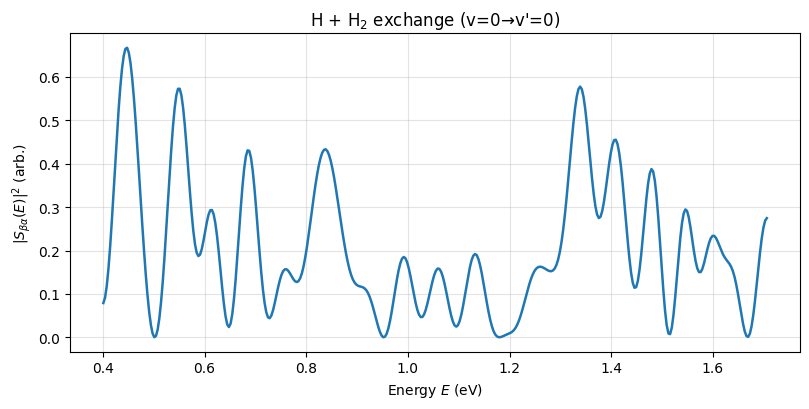

In [15]:
import numpy as np
import matplotlib.pyplot as plt

HARTREE_TO_EV = 27.211386245988  # eV / a.u.

def fft_C_to_energy_eV(ts, Re_vals, Im_vals, zero_pad=8, window='hann'):
    ts = np.asarray(ts, float)
    dt = ts[1] - ts[0]
    C = np.asarray(Re_vals, complex) + 1j*np.asarray(Im_vals, complex)

    # window
    if window == 'hann':
        w = 0.5 - 0.5*np.cos(2*np.pi*np.arange(len(ts))/(len(ts)-1))
    else:
        w = np.ones_like(ts)

    # zero-padding for smoother spectrum (doesn't change Nyquist)
    n  = len(ts)
    N  = int(2**np.ceil(np.log2(n*zero_pad)))
    pad = N - n
    Cw = w * C
    Cw = np.pad(Cw, (pad//2, pad - pad//2))

    # forward transform for ∫ e^{+iEt} C(t) dt  (ħ=1)
    F = np.fft.fftshift(np.fft.fft(Cw)) * dt
    freqs = np.fft.fftshift(np.fft.fftfreq(N, d=dt))  # cycles/a.u.
    E_au  = 2*np.pi*freqs                              # a.u.
    E_eV  = E_au * HARTREE_TO_EV                       # eV

    # normalized power (no η-prefactors; use your normalized formula if desired)
    P = np.abs(F)**2
    if P.max() > 0: P /= P.max()
    return E_eV, P, dt

def plot_energy_window(E_eV, P, lo=0.4, hi=2.4, dt=None):
    Emax_eV = (np.pi/dt) * HARTREE_TO_EV
    if hi > Emax_eV:
        print(f"[note] dt={dt:g} a.u. → E_max≈π/dt={Emax_eV:.3f} eV; "
              f"plot will truncate at {min(hi,Emax_eV):.3f} eV.")
    sel = (E_eV >= lo) & (E_eV <= min(hi, Emax_eV))
    plt.figure(figsize=(8.2,4.2))
    plt.plot(E_eV[sel], P[sel], lw=1.8)
    plt.xlabel("Energy $E$ (eV)")
    plt.ylabel(r"$|S_{\beta\alpha}(E)|^2$ (arb.)")
    plt.title("H + H$_2$ exchange (v=0→v'=0)")
    plt.grid(True, alpha=0.35)
    plt.tight_layout(); plt.show()

# ---- Use with your data (from the snippet you posted) ----
E_eV, P, dt = fft_C_to_energy_eV(ts, Re_vals, Im_vals, zero_pad=8, window='hann')
plot_energy_window(E_eV, P, lo=0.4, hi=2.4, dt=dt)


In [16]:
import numpy as np
import matplotlib.pyplot as plt

HARTREE_TO_EV = 27.211386245988  # eV / a.u.

def kale_kais_prefactor(E_au, mu, Delta_k, k0_in, k0_out,
                        E_in=0.0, E_out=0.0,
                        sign_in=-1, sign_out=+1):
    """
    Kale–Kais prefactor:
        sqrt(|k_out*k_in|) / (2π μ η_-* η_+)
    with η modelled as Gaussians in k.
    """
    E = np.asarray(E_au)

    # channel kinetic energies
    arg_in  = np.maximum(E - E_in, 0.0)
    arg_out = np.maximum(E - E_out, 0.0)

    k_in  = sign_in  * np.sqrt(2.0 * mu * arg_in)
    k_out = sign_out * np.sqrt(2.0 * mu * arg_out)

    # Gaussian η(k)
    eta_plus  = np.exp(-(k_in  - k0_in )**2 / (4.0 * Delta_k**2))
    eta_minus = np.exp(-(k_out - k0_out)**2 / (4.0 * Delta_k**2))

    denom = eta_minus.conjugate() * eta_plus
    denom[np.abs(denom) < 1e-14] = np.nan  # avoid blow-ups

    pref = np.sqrt(np.abs(k_out * k_in)) / (2.0 * np.pi * mu * denom)
    return pref


def gaussian_smooth_energy(E_eV, P, sigma_eV=0.05):
    """
    Convolve P(E) with a Gaussian in energy, to mimic finite
    resolution and smooth out unphysical spikiness.
    """
    E = np.asarray(E_eV)
    P = np.asarray(P)
    dE = E[1] - E[0]

    # kernel half-width ~ 4σ
    m = int(4.0 * sigma_eV / dE)
    if m < 1:
        return P  # grid already coarser than σ

    k = np.arange(-m, m+1)
    g = np.exp(-0.5 * (k * dE / sigma_eV)**2)
    g /= g.sum()

    P_smooth = np.convolve(P, g, mode="same")
    return P_smooth

def fft_C_to_energy_eV(ts, Re_vals, Im_vals, zero_pad=8,
                       mu=1.0,
                       Delta_k=1.25, k0_in=-8.2, k0_out=+8.2,
                       smooth_sigma_eV=0.05):
    """
    Kale–Kais style S(E) from C(t).
    """
    ts = np.asarray(ts, float)
    dt = ts[1] - ts[0]
    C  = np.asarray(Re_vals, float) + 1j*np.asarray(Im_vals, float)

    # --- enforce symmetry in time ---
    tmin, tmax = ts.min(), ts.max()
    if abs(abs(tmin) - abs(tmax)) > 1e-12:
        T = max(abs(tmin), abs(tmax))
        N = len(ts)
        ts_sym = np.linspace(-T, T, N)
        C = np.interp(ts_sym, ts, C)
        ts = ts_sym

    # *** NO DC SUBTRACTION HERE ***
    # C -= C[np.argmin(np.abs(ts))]

    # Hann window in time
    n = len(ts)
    w = 0.5 - 0.5 * np.cos(2.0*np.pi*np.arange(n)/(n-1))
    Cw = C * w

    # zero padding
    Npad = int(2**np.ceil(np.log2(n * zero_pad)))
    pad = Npad - n
    Cw = np.pad(Cw, (pad//2, pad - pad//2))

    # FFT for ∫ e^{iEt} C(t) dt
    F = np.fft.fftshift(np.fft.fft(Cw)) * dt
    freqs = np.fft.fftshift(np.fft.fftfreq(Npad, d=dt))

    E_au = 2.0 * np.pi * freqs
    E_eV = E_au * HARTREE_TO_EV

    # Kale–Kais prefactor
    pref = kale_kais_prefactor(E_au, mu, Delta_k, k0_in, k0_out)
    S_E  = pref * F

    P = np.abs(S_E)**2

#     # keep only E >= 0 (physical)
#     keep = (E_au >= 0.0)
#     E_eV = E_eV[keep]
#     P = P[keep]

    # optional energy smoothing
    if smooth_sigma_eV is not None and smooth_sigma_eV > 0.0:
        P = gaussian_smooth_energy(E_eV, P, sigma_eV=smooth_sigma_eV)

    # normalize
    if np.nanmax(P) > 0:
        P /= np.nanmax(P)

    return E_eV, P, dt



def plot_energy_window(E_eV, P, lo=0.5, hi=2.5):
    mask = (E_eV >= lo) & (E_eV <= hi)
    plt.figure(figsize=(8,4))
    plt.plot(E_eV[mask], P[mask], lw=2)
    plt.xlabel("Energy $E$ (eV)")
    plt.ylabel(r"$|S_{\beta\alpha}(E)|^2$")
    plt.title("H + H$_2$ scattering (Kale–Kais)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


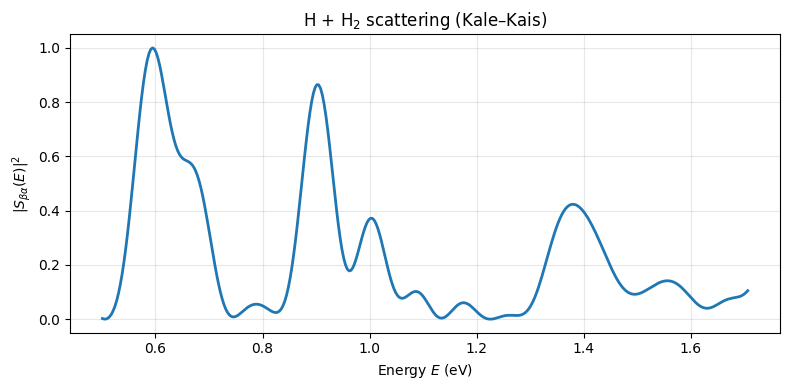

In [17]:
E_eV, P, dt = fft_C_to_energy_eV(
    ts, Re_vals, Im_vals,
    Delta_k=1.25, k0_in=-8.2, k0_out=+8.2,
    smooth_sigma_eV=0.00  # instead of 0.05
)

plot_energy_window(E_eV, P)


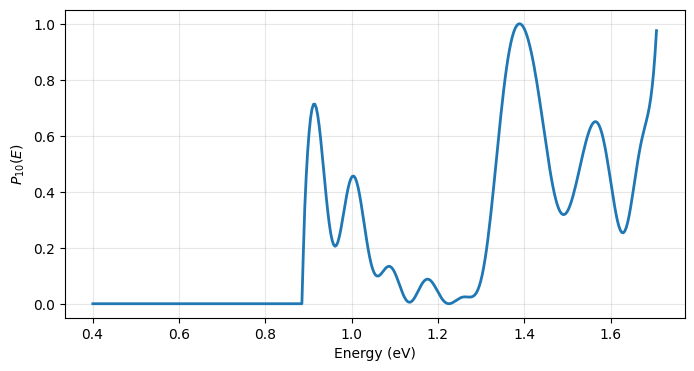

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

HARTREE_TO_EV = 27.211386245988  # eV / a.u.


# ============================================================
# 1. Build 1D vibrational coordinate grid
# ============================================================
# r2 MUST exist in your notebook already from the (R, r) simulation.
# We extract the 1D r-axis from it.
r_grid = np.unique(r2.ravel())
r_grid.sort()


# ============================================================
# 2. Morse vibrational eigenfunctions φ_v(r)
# ============================================================
def morse_eigenstates(r_grid,
                      De=0.1745, a=1.02, re=1.4,
                      mu=918.076, nmax=3):
    r = np.asarray(r_grid, float)
    dr = r[1] - r[0]
    N  = len(r)

    # Morse potential
    V = De * (1 - np.exp(-a*(r - re)))**2

    # finite-difference KE: T = -1/(2μ) d²/dr²
    t_fac = 1.0/(2.0 * mu * dr**2)
    main_diag = 2*t_fac + V
    off_diag  = -t_fac * np.ones(N-1)

    Evals, Evecs = eigh_tridiagonal(main_diag, off_diag)

    E_v   = Evals[:nmax]
    phi_v = Evecs[:, :nmax]

    # normalize
    for j in range(nmax):
        nj = np.sqrt(np.trapz(np.abs(phi_v[:, j])**2, r))
        phi_v[:, j] /= nj

    return E_v, phi_v


E_v_au, phi_vs = morse_eigenstates(r_grid, nmax=3)
phi_v0 = phi_vs[:,0]
phi_v1 = phi_vs[:,1]
phi_v2 = phi_vs[:,2]


# ============================================================
# 3. η_+(k) incoming Gaussian
# ============================================================
def eta_plus(k, Delta_k=1.25, k0_in=-8.2):
    k = np.asarray(k, float)
    return np.exp(-(k - k0_in)**2 / (4 * Delta_k**2))


# ============================================================
# 4. η_-(k') = ∫ φ_{v'}(r) e^{-ik'r} dr
# ============================================================
def eta_minus_from_phi(k_out, phi_vprime, r_grid):
    k_out = np.asarray(k_out, float)
    r     = np.asarray(r_grid, float)
    phi   = np.asarray(phi_vprime, complex)

    vals = []
    for k in k_out:
        vals.append(np.trapz(phi * np.exp(-1j*k*r), r))

    return np.array(vals, dtype=complex)


# ============================================================
# 5. Kale–Kais prefactor (full Eq. 10)
# ============================================================
def kale_kais_prefactor(E_au, mu, Delta_k, k0_in,
                        phi_vprime, r_grid,
                        E_in=0.0, E_out=0.0,
                        sign_in=-1, sign_out=+1):

    E = np.asarray(E_au, float)

    # kinetic energies
    arg_in  = np.maximum(E - E_in,  0.0)
    arg_out = np.maximum(E - E_out, 0.0)

    # momenta
    k_in  = sign_in  * np.sqrt(2.0*mu*arg_in)
    k_out = sign_out * np.sqrt(2.0*mu*arg_out)

    # η terms
    eta_p = eta_plus(k_in, Delta_k=Delta_k, k0_in=k0_in)
    eta_m = eta_minus_from_phi(k_out, phi_vprime, r_grid)

    denom = eta_m.conjugate() * eta_p
    denom[np.abs(denom) < 1e-14] = np.nan

    pref = np.sqrt(np.abs(k_in*k_out)) / (2*np.pi*mu * denom)
    return pref


# ============================================================
# 6. FFT C(t) → S(E)
# ============================================================
def fft_C_to_energy_eV(ts, Re_vals, Im_vals,
                       phi_vprime, r_grid,
                       zero_pad=8, mu=918.076,
                       Delta_k=1.25, k0_in=-8.2,
                       smooth_sigma_eV=0.03,
                       E_in_eV=0.0, E_out_eV=0.0):

    ts = np.asarray(ts, float)
    C  = np.asarray(Re_vals) + 1j*np.asarray(Im_vals)
    dt = ts[1] - ts[0]

    # symmetrize time grid
    tmin, tmax = ts.min(), ts.max()
    if abs(abs(tmin) - abs(tmax)) > 1e-12:
        T = max(abs(tmin), abs(tmax))
        N = len(ts)
        ts2 = np.linspace(-T, T, N)
        C   = np.interp(ts2, ts, C)
        ts  = ts2

    # Hann
    n = len(ts)
    w = 0.5 - 0.5*np.cos(2*np.pi*np.arange(n)/(n-1))
    Cw = C * w

    # padding
    Npad = int(2**np.ceil(np.log2(n * zero_pad)))
    pad  = Npad - n
    Cw   = np.pad(Cw, (pad//2, pad-pad//2))

    # FFT
    F = np.fft.fftshift(np.fft.fft(Cw)) * dt
    freqs = np.fft.fftshift(np.fft.fftfreq(Npad, d=dt))

    E_au = 2*np.pi*freqs
    E_eV = E_au * HARTREE_TO_EV

    # vibrational
    E_in_au  = E_in_eV  / HARTREE_TO_EV
    E_out_au = E_out_eV / HARTREE_TO_EV

    # prefactor
    pref = kale_kais_prefactor(E_au, mu, Delta_k, k0_in,
                               phi_vprime, r_grid,
                               E_in=E_in_au, E_out=E_out_au)

    S_E = pref * F
    P   = np.abs(S_E)**2

    keep = (E_au >= 0)
    E_eV = E_eV[keep]
    P    = P[keep]

    # smooth
    if smooth_sigma_eV>0:
        dE = E_eV[1] - E_eV[0]
        m  = int(4*smooth_sigma_eV/dE)
        if m>0:
            k  = np.arange(-m,m+1)
            g  = np.exp(-0.5*(k*dE/smooth_sigma_eV)**2)
            g /= g.sum()
            P  = np.convolve(P,g,mode='same')

    if P.max()>0:
        P /= P.max()

    return E_eV, P, dt


# ============================================================
# 7. Compute P10 using *your* correlation function
# ============================================================
# IMPORTANT: your code produced Re_vals, Im_vals as C_{1←0}(t)

E_v0 = 0.27
E_v1 = 0.78
E_v0 = E_v_au[0] * HARTREE_TO_EV
E_v1 = E_v_au[1] * HARTREE_TO_EV
E_v2 = E_v_au[2] * HARTREE_TO_EV

phi_vprime = phi_v1

E_eV_10, P_10, dt = fft_C_to_energy_eV(
    ts, Re_vals, Im_vals,
    phi_vprime, r_grid,
    mu=918.076,
    Delta_k=1.25, k0_in=-8.2,
    smooth_sigma_eV=0.00,
    E_in_eV=E_v0,   # from Morse
    E_out_eV=E_v1,
    # from Morse
)



# ============================================================
# 8. Plot
# ============================================================
plt.figure(figsize=(8,4))
mask = (E_eV_10>=0.4)&(E_eV_10<=2.4)
plt.plot(E_eV_10[mask], P_10[mask], lw=2)
plt.xlabel("Energy (eV)")
plt.ylabel(r"$P_{10}(E)$")
plt.grid(True,alpha=0.3)
plt.show() 

In [19]:

# import numpy as np, cirq
# from scipy.linalg import expm

# # --- your qubits ---
# ancilla = cirq.LineQubit(0)
# n_sys  = int(np.log2(NX*NY))
# system_qubits   = [cirq.LineQubit(i+1)           for i in range(n_sys)]       # register A
# system_qubits_B = [cirq.LineQubit(1+n_sys+i)     for i in range(n_sys)]       # register B (for SWAP tests)

# sim = cirq.Simulator(dtype=np.complex128)

# # |R> = |0...0> on an n_sys-qubit register
# R = np.eye(1, 1<<n_sys, 0).ravel()

# # φ_i ≡ ψ_p (product = bra),  φ_j ≡ ψ_r (reactant = ket)
# prep_phi_i = cirq.StatePreparationChannel(psi_p, name="prep_phi_i")   # |φ_i>
# prep_phi_j = cirq.StatePreparationChannel(psi_r, name="prep_phi_j")   # |φ_j>

# sup_i_vec  = (R + psi_p)/np.linalg.norm(R + psi_p)   # (|R>+|φ_i>)/√2
# sup_j_vec  = (R + psi_r)/np.linalg.norm(R + psi_r)   # (|R>+|φ_j>)/√2
# prep_sup_i = cirq.StatePreparationChannel(sup_i_vec, name="prep_sup_i")
# prep_sup_j = cirq.StatePreparationChannel(sup_j_vec, name="prep_sup_j")


# ReC, ImC, AbsC = [], [], []
# dimAB = 1 << (2*n_sys)   # size of anc=0 (or anc=1) half-block when qubit_order=[ancilla, *A, *B]

# for t in ts:
#     # --- exact propagator U(t) = e^{-i H t} (dense) ---
#     U = expm(((-1j) * H_sparse).toarray() * t)
#     U_gate = cirq.MatrixGate(U, name="U")
#     Uprop0 = expm((-1j * H0).toarray() * t)
#     Uprop0pos = expm((1j * H0).toarray() * t)
#     Ut0 = cirq.MatrixGate(Uprop0, name="Ut0")
#     Ut0p = cirq.MatrixGate(Uprop0pos, name="Ut0-")
#     Uproppos = expm((1j * H_sparse).toarray() * t)
#     Utp   = cirq.MatrixGate(Uproppos, name="U_tp")

#     # ---------------- F1 = |<φ_i| U |φ_j>|^2 via SWAP test ----------------
#     c_F1 = cirq.Circuit()
#     c_F1.append(prep_phi_i.on(*system_qubits))        # |φ_i> on A
#     c_F1.append(Ut0.on(*system_qubits))
#     c_F1.append(Utp.on(*system_qubits))
#     c_F1.append(prep_phi_j.on(*system_qubits_B))      # |φ_j> on B
#     c_F1.append(Ut0p.on(*system_qubits_B)) 
#     c_F1.append(U_gate.on(*system_qubits_B))
#     c_F1.append(U_gate.on(*system_qubits_B))          # U|φ_j> on B

#     c_F1.append(cirq.H(ancilla))
#     for qa, qb in zip(system_qubits, system_qubits_B):
#         c_F1.append(cirq.CSWAP(ancilla, qa, qb))
#     c_F1.append(cirq.H(ancilla))

#     sv1 = sim.simulate(c_F1, qubit_order=[ancilla, *system_qubits, *system_qubits_B]).final_state_vector
#     p0_F1 = np.sum(np.abs(sv1[:dimAB])**2)           # anc=0 probability
#     F1 = np.clip(2.0*p0_F1 - 1.0, 0.0, 1.0)

#     # --------------- F2 = (1/4)*|(<φ_i|+<R|) U (|R>+|φ_j>)|^2 ---------------
#     c_F2 = cirq.Circuit()
#     c_F2.append(prep_sup_i.on(*system_qubits))        # (|R>+|φ_i>)/√2 on A
#     c_F2.append(Ut0.on(*system_qubits))
#     c_F2.append(Utp.on(*system_qubits))
#     c_F2.append(prep_sup_j.on(*system_qubits_B))      # (|R>+|φ_j>)/√2 on B
#     c_F2.append(Ut0p.on(*system_qubits_B)) 
#     c_F2.append(U_gate.on(*system_qubits_B))
#     c_F2.append(U_gate.on(*system_qubits_B))          # U on B

#     c_F2.append(cirq.H(ancilla))
#     for qa, qb in zip(system_qubits, system_qubits_B):
#         c_F2.append(cirq.CSWAP(ancilla, qa, qb))
#     c_F2.append(cirq.H(ancilla))

#     sv2 = sim.simulate(c_F2, qubit_order=[ancilla, *system_qubits, *system_qubits_B]).final_state_vector
#     p0_F2 = np.sum(np.abs(sv2[:dimAB])**2)
#     F2 = np.clip(2.0*p0_F2 - 1.0, 0.0, 1.0)   # <-- no 1/4


#     # -------- reference sector: <R|U|R> = r_R e^{i θ_R} on the SAME U(t) --------
#     amp_R  = U[0, 0]                     # ⟨0…0|U|0…0⟩
#     r_R    = np.abs(amp_R)
#     theta_R= np.angle(amp_R)

#     # -------- assemble C_ij(t) = r e^{iθ} (paper’s MFE equations) --------
#     r = np.sqrt(max(F1, 0.0))
#     denom = max(2.0 * r_R * r, 1e-16)
#     arg = np.clip((4.0*F2 - F1 - r_R**2)/denom, -1.0, 1.0)
#     theta = np.arccos(arg) + theta_R
#     C = r * np.exp(1j * theta)

#     ReC.append(C.real); ImC.append(C.imag); AbsC.append(abs(C))


In [20]:
# # --- Plot 1: Real and Imaginary parts ---
# plt.figure(figsize=(7,4))
# plt.plot(ts, ReC, 'o-', label='Re C(t)')
# plt.plot(ts, ImC, 's-', label='Im C(t)')
# plt.xlabel('t (a.u.)')
# plt.ylabel('Correlation')
# plt.title('Real and Imaginary parts of C(t)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # --- Plot 2: Magnitude |C(t)| ---
# plt.figure(figsize=(7,4))
# # plt.plot(ts, AbsC, '--', label='|C(t)|')
# plt.plot(ts, AbsC, '-', label='|C(t)|')
# plt.xlabel('t (a.u.)')
# plt.ylabel('|C(t)|')
# # plt.title('Absolute value of C(t)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
